# nb-model_xg-model-wst

In [1]:
import sys
import os
from os import sep
from os.path import dirname, realpath
from pathlib import Path
from collections import OrderedDict
from functools import partial, reduce
import logging

def get_cwd(fname, subdir, crunch_dir=realpath(Path.home()) +sep +'crunch' +sep):
    """
    Convenience function to make a directory string for the current file based on inputs.
    Jupyter Notebook in Anaconda invokes the Python interpreter in Anaconda's subdirectory
    which is why changing sys.argv[0] is necessary. In the future a better way to do this
    should be preferred..
    """
    return crunch_dir +subdir +fname

def fix_path(cwd):
    """
    Convenience function to fix argv and python path so that jupyter notebook can run the same as
    any script in crunch.
    """
    sys.argv[0] = cwd
    module_path = os.path.abspath(os.path.join('..'))
    if module_path not in sys.path:
        sys.path.append(module_path)

fname = 'nb-model_xg-model-fr-model.ipynb'
dir_name = 'model'
fix_path(get_cwd(fname, dir_name +sep))

import numpy as np
import pandas as pd
#import matplotlib.pyplot as plt
from dask import delayed, compute
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data.dataset import Dataset as TorchDataset
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import weight_norm
import torchfunc
from torchmeta.utils.data import BatchMetaDataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
from kymatio.numpy import Scattering1D as np_wavelet_scatter_1d
from kymatio.torch import Scattering1D as pyt_wavelet_scatter_1d
from kymatio.scattering1d.filter_bank import scattering_filter_factory
import matplotlib.pyplot as plt

from ipywidgets import interact, interactive, fixed
from IPython.display import display

pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 50)

from common_util import MODEL_DIR, RECON_DIR, JSON_SFX_LEN, DT_CAL_DAILY_FREQ, pd_to_np, pairwise, df_midx_restack, compose, is_type, df_rows_in_year, list_all_eq, remove_dups_list, NestedDefaultDict, set_loglevel, search_df, chained_filter, get_variants, load_df, dump_df, load_json, gb_transpose, pd_common_index_rows, filter_cols_below, inner_join, outer_join, ser_shift, list_get_dict, window_iter, benchmark
from common_util import pd_rows_key_in, df_add_midx_level, df_del_midx_level, pd_split_ternary_to_binary, np_value_counts, isnt, window_iter, all_eq, np_assert_identical_len_dim, pd_idx_rename, midx_get_level, pd_rows, midx_intersect, pd_get_midx_level, pd_common_idx_rows, midx_split, pd_midx_to_arr, window_iter, np_at_least_nd, np_is_ndim, identity_fn
from model.common import DATASET_DIR, XG_PROCESS_DIR, XG_DATA_DIR, XG_DIR, PYTORCH_MODELS_DIR, TEST_RATIO, VAL_RATIO, EXPECTED_NUM_HOURS, default_dataset
from model.common import PYTORCH_ACT_MAPPING, PYTORCH_OPT_MAPPING, PYTORCH_SCH_MAPPING, PYTORCH_LOSS_MAPPING
from model.xg_util import xgload, get_xg_feature_dfs, get_xg_label_target_dfs
from model.preproc_util import temporal_preproc_3d, stride_preproc_3d
from model.train_util import pd_to_np_tvt, batchify
from model.pl_generic import GenericModel
from model.model_util import OutputLinear
logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)

/home/kev/miniconda3/lib/python3.7/site-packages/matplotlib/backend_bases.py:57: DeprecationWarning: PILLOW_VERSION is deprecated and will be removed in a future release. Use __version__ instead.
  from PIL import PILLOW_VERSION
CRITICAL:root:script location: /home/kev/crunch/model/nb-model_xg-model-fr-model.ipynb
CRITICAL:root:using project dir: /home/kev/crunch/


Wavelet Scattering Transform

## Load Data

In [2]:
assets = ['sp_500', 'russell_2000', 'nasdaq_100', 'dow_jones']
chosen_asset = assets[0]

In [3]:
fd = get_xg_feature_dfs(chosen_asset)
ld, td = get_xg_label_target_dfs(chosen_asset)

INFO:root:pba_dohlca_ddiff(1)
INFO:root:pba_hlh_hdxret_ddir
INFO:root:pba_hoc_hdxret_ddir
INFO:root:pba_hlh_hdxret1(1.000000%)_ddir1_hdxret1(2.000000%)_hdxret1(3.000000%)_hdxret1(4.000000%)_hdxret1(5.000000%)_hdxret1(6.000000%)_hdxret1(7.000000%)_hdxret1(8.000000%)
INFO:root:pba_hoc_hdxret1(1.000000%)_ddir1_hdxret1(2.000000%)_hdxret1(3.000000%)_hdxret1(4.000000%)_hdxret1(5.000000%)_hdxret1(6.000000%)_hdxret1(7.000000%)_hdxret1(8.000000%)
INFO:root:pba_hlh_hdxret1(0.062500%)_ddir1_hdxret1(0.125000%)_hdxret1(0.250000%)_hdxret1(0.500000%)_hdxret1(1.000000%)_hdxret1(2.000000%)_hdxret1(4.000000%)_hdxret1(8.000000%)
INFO:root:pba_hoc_hdxret1(0.062500%)_ddir1_hdxret1(0.125000%)_hdxret1(0.250000%)_hdxret1(0.500000%)_hdxret1(1.000000%)_hdxret1(2.000000%)_hdxret1(4.000000%)_hdxret1(8.000000%)
INFO:root:pba_hlh_hdxret2(0.5*avg,1)_ddir2_hdxret2(1*avg,1)_hdxret2(2*avg,1)
INFO:root:pba_hoc_hdxret2(0.5*avg,1)_ddir2_hdxret2(1*avg,1)_hdxret2(2*avg,1)
INFO:root:pba_hlh_hdxret2(0.5*mad,1)_ddir2_hdxret2(1

INFO:root:pba_hoc_hdxcret2(0.5*std,1)_dxfbval2_hdxcret2(1*std,1)_hdxcret2(2*std,1)
INFO:root:vol_dohlca_ddiff(1)
INFO:root:vol_hlh_hdxret_ddir
INFO:root:vol_hoc_hdxret_ddir
INFO:root:vol_hlh_hdxret1(1.000000%)_ddir1_hdxret1(2.000000%)_hdxret1(3.000000%)_hdxret1(4.000000%)_hdxret1(5.000000%)_hdxret1(6.000000%)_hdxret1(7.000000%)_hdxret1(8.000000%)
INFO:root:vol_hoc_hdxret1(1.000000%)_ddir1_hdxret1(2.000000%)_hdxret1(3.000000%)_hdxret1(4.000000%)_hdxret1(5.000000%)_hdxret1(6.000000%)_hdxret1(7.000000%)_hdxret1(8.000000%)
INFO:root:vol_hlh_hdxret1(0.062500%)_ddir1_hdxret1(0.125000%)_hdxret1(0.250000%)_hdxret1(0.500000%)_hdxret1(1.000000%)_hdxret1(2.000000%)_hdxret1(4.000000%)_hdxret1(8.000000%)
INFO:root:vol_hoc_hdxret1(0.062500%)_ddir1_hdxret1(0.125000%)_hdxret1(0.250000%)_hdxret1(0.500000%)_hdxret1(1.000000%)_hdxret1(2.000000%)_hdxret1(4.000000%)_hdxret1(8.000000%)
INFO:root:vol_hlh_hdxret2(0.5*avg,1)_ddir2_hdxret2(1*avg,1)_hdxret2(2*avg,1)
INFO:root:vol_hoc_hdxret2(0.5*avg,1)_ddir2_hdx

INFO:root:vol_hlh_hdxcret2(0.5*std,1)_dxfbval2_hdxcret2(1*std,1)_hdxcret2(2*std,1)
INFO:root:vol_hoc_hdxcret2(0.5*std,1)_dxfbval2_hdxcret2(1*std,1)_hdxcret2(2*std,1)
INFO:root:trmi3_etf3_news_buzz_dohlca_ddiff(1)_mkt3_bondBuzz_ratesBuzz_stockIndexBuzz
INFO:root:trmi3_etf3_social_buzz_dohlca_ddiff(1)_mkt3_bondBuzz_ratesBuzz_stockIndexBuzz
INFO:root:trmi3_etf3_news_buzz_dohlca_dffd(0.200000,0.010000)_dffd(0.400000,0.010000)_dffd(0.600000,0.010000)_dffd(0.800000,0.010000)_mkt3_bondBuzz_ratesBuzz_stockIndexBuzz
INFO:root:trmi3_etf3_social_buzz_dohlca_dffd(0.200000,0.010000)_dffd(0.400000,0.010000)_dffd(0.600000,0.010000)_dffd(0.800000,0.010000)_mkt3_bondBuzz_ratesBuzz_stockIndexBuzz
INFO:root:trmi3_etf3_news_buzz_dohlca_mkt3_bondBuzz_ratesBuzz_stockIndexBuzz
INFO:root:trmi3_etf3_social_buzz_dohlca_mkt3_bondBuzz_ratesBuzz_stockIndexBuzz
INFO:root:trmi3_etf3_news_buzz_dohlca_dwrmx(-1)_dwrmx(20)_dwrmx(240)_dwrmx(5)_mkt3_bondBuzz_ratesBuzz_stockIndexBuzz
INFO:root:trmi3_etf3_social_buzz_dohlca

In [4]:
d_all_common = ['dwrmx', 'dwrod', 'dwrpt', 'dwrzn', 'dffd']
d_extra = ['dlogret', 'dohlca', 'ddiff', 'dc', 'dwrxmx']

In [5]:
h_all_common = ['hdmx', 'hdod', 'hdpt', 'hdzn']
h_extra = ['hdgau', 'hduni', 'hohlca']

Test axefiles per asset and source (4 * 4 * 5 + 4 * 3 * 4 = ~128 tests) , what model to use?
* TCN
* XGBOOST
* RF

OR I just make a best guess on the best features. I record the tensor dimensions (allow easy modification) and get going on the meat of this stuff. I can start with only h/d pba, play with that until it's working well then iteratively add other sources.

I start with one asset, move to others after the first asset's model works.

I know roughly what features to use. I need to now determine the model design.

In [6]:
h_all_common, d_all_common

(['hdmx', 'hdod', 'hdpt', 'hdzn'],
 ['dwrmx', 'dwrod', 'dwrpt', 'dwrzn', 'dffd'])

## Select Data

### Choose Features and Join

In [7]:
for k0, v0 in fd.items():
    print(k0)
    for k1,v1 in fd[k0].items():
        print('\t' +k1)
        for k2, v2 in fd[k0][k1].items():
            print('\t\t' +k2)
            for k3, v3 in fd[k0][k1][k2].items():
                print('\t\t\t' +k3)

d
	pba
		ddiff
			pba_dohlca_ddiff(1)
		ddir
			pba_hlh_hdxret_ddir
			pba_hoc_hdxret_ddir
		ddir1
			pba_hlh_hdxret1(1.000000%)_ddir1_hdxret1(2.000000%)_hdxret1(3.000000%)_hdxret1(4.000000%)_hdxret1(5.000000%)_hdxret1(6.000000%)_hdxret1(7.000000%)_hdxret1(8.000000%)
			pba_hoc_hdxret1(1.000000%)_ddir1_hdxret1(2.000000%)_hdxret1(3.000000%)_hdxret1(4.000000%)_hdxret1(5.000000%)_hdxret1(6.000000%)_hdxret1(7.000000%)_hdxret1(8.000000%)
			pba_hlh_hdxret1(0.062500%)_ddir1_hdxret1(0.125000%)_hdxret1(0.250000%)_hdxret1(0.500000%)_hdxret1(1.000000%)_hdxret1(2.000000%)_hdxret1(4.000000%)_hdxret1(8.000000%)
			pba_hoc_hdxret1(0.062500%)_ddir1_hdxret1(0.125000%)_hdxret1(0.250000%)_hdxret1(0.500000%)_hdxret1(1.000000%)_hdxret1(2.000000%)_hdxret1(4.000000%)_hdxret1(8.000000%)
		ddir2
			pba_hlh_hdxret2(0.5*avg,1)_ddir2_hdxret2(1*avg,1)_hdxret2(2*avg,1)
			pba_hoc_hdxret2(0.5*avg,1)_ddir2_hdxret2(1*avg,1)_hdxret2(2*avg,1)
			pba_hlh_hdxret2(0.5*mad,1)_ddir2_hdxret2(1*mad,1)_hdxret2(2*mad,1)
			pba_

In [8]:
#for ser_name in chosen_f.index.unique(level='id1'):
#    print('\t' +ser_name)
#    ser_subset_df = chosen_f.xs(ser_name, level=1, drop_level=False)
#    ser_subset_df.index = ser_subset_df.index.remove_unused_levels()
#    display(pd_to_np(ser_subset_df))
#    ser_subset_df.isnan()
#    np.isnan(ser_subset_df.values).any()

In [9]:
from xg_util import get_hardcoded_daily_dfs, get_hardcoded_hourly_dfs

In [10]:
def df_filter_by_keywords(fdf, keywords):
	cols = [col for col in fdf.index.levels[1] if (any(keyword in col for keyword in keywords))]
	return pd_rows_key_in(fdf, 'id1', cols)

def get_hardcoded_daily_dfs(fd, src):
	"""
	Return hardcoded daily freq feature dfs to use in experiments.
	"""
	feature_dfs = []

	#if (src in ('pba', 'vol')):
	#	feature_dfs.append(fd['d'][src]['dlogret']['{src}_dlh_dlogret'.format(src=src)])

	if (src in ('pba', 'vol', 'buzz')):
		for axe in ('dwrmx', 'dwrod', 'dwrpt', 'dwrzn', 'dffd'):
		#for axe in ('dwrmx', 'dwrod', 'dwrpt', 'dwrzn'):
			for fdf in fd['d'][src][axe].values():
				#feature_dfs.append(df_filter_by_keywords(fdf, ('avgPrice', 'high', 'low')))
				#feature_dfs.append(df_filter_by_keywords(fdf, ('avgPrice', 'high', 'low', 'close')))
				feature_dfs.append(fdf)
				#feature_dfs.append(df_filter_by_keywords(df_filter_by_keywords(fdf, ('avgPrice', 'high', 'low')), ('(5)', '(20)',)))

	if (src in ('nonbuzz',)):
		for axe in ('dffd', 'dwrxmx'):
			for fdf in fd['d'][src][axe].values():
				feature_dfs.append(fdf)

	#return pd.concat(feature_dfs).sort_index(axis=0)
	return pd.concat(feature_dfs)

def get_hardcoded_hourly_dfs(fd, src):
	"""
	Return hardcoded hourly freq feature dfs to use in experiments.
	"""
	feature_dfs = []

	if (src in ('pba', 'vol', 'buzz')):
		for axe in ('hdmx', 'hdod', 'hdpt', 'hdzn', 'hdgau', 'hduni'):
			for fdf in fd['h'][src][axe].values():
				#feature_dfs.append(df_filter_by_keywords(fdf, ('avgPrice', 'high', 'low', 'close')))
				feature_dfs.append(fdf)

	return pd.concat(feature_dfs)

In [11]:
d_pba = get_hardcoded_daily_dfs(fd, 'pba')
d_vol = get_hardcoded_daily_dfs(fd, 'vol')
d_buzz = get_hardcoded_daily_dfs(fd, 'buzz')
d_nonbuzz = get_hardcoded_daily_dfs(fd, 'buzz')
h_pba = get_hardcoded_hourly_dfs(fd, 'pba')
h_vol = get_hardcoded_hourly_dfs(fd, 'vol')
h_buzz = get_hardcoded_hourly_dfs(fd, 'buzz')

In [12]:
# Returns (AR)
chosen_f = fd['d']['pba']['dret']['pba_hlh_hdxret_dret']
chosen_f = fd['d']['pba']['dret']['pba_hoc_hdxret_dret']
#chosen_f = fd['d']['pba']['ddir']['pba_hoc_hdxret_ddir']

In [13]:
# Daily Features
chosen_f = d_pba
chosen_f = fd['d']['pba']['ddir']['pba_hoc_hdxret_ddir']

In [14]:
# Hourly Features
chosen_f = h_pba
chosen_f = fd['h']['pba']['hdmx']['pba_hohlca_hdmx']

In [15]:
# Random 'Features':
dret = fd['d']['pba']['dret']['pba_hoc_hdxret_dret']
rand_f = pd.DataFrame(np.random.rand(len(dret)), index=dret.index).rename({dret.index.levels[1][0]: 'rand'})

In [16]:
chosen_f = rand_f

In [15]:
dret_hoc = fd['d']['pba']['dret']['pba_hoc_hdxret_dret'].values.T[0]
dret_hlh = fd['d']['pba']['dret']['pba_hlh_hdxret_dret'].values.T[0]
pba_ddiff = fd['d']['pba']['ddiff']['pba_dohlca_ddiff(1)'].unstack()[(-1, 'pba_avgPrice_pba_dohlca_ddiff(1)')].values
pba_dffd = fd['d']['pba']['dffd']['pba_dohlca_dffd(0.200000,0.010000)_dffd(0.400000,0.010000)_dffd(0.600000,0.010000)_dffd(0.800000,0.010000)'] \
    .unstack()[(-1, 'pba_avgPrice_pba_dohlca_dffd(0.800000,0.010000)')].values

In [16]:
decomp_signal = pba_ddiff

Text(0.5, 1.0, 'Original signal')

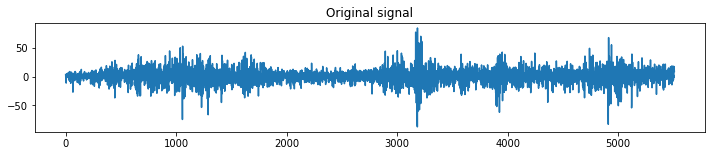

In [17]:
plt.figure(figsize=(12, 2))
plt.plot(decomp_signal)
plt.title("Original signal")

Text(0.5, 1.0, 'Time-Frequency spectrogram of signal')

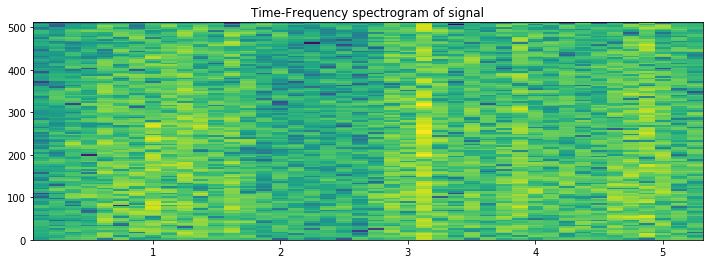

In [18]:
plt.figure(figsize=(12, 4))
plt.specgram(decomp_signal, Fs=1024)
plt.title("Time-Frequency spectrogram of signal")

345


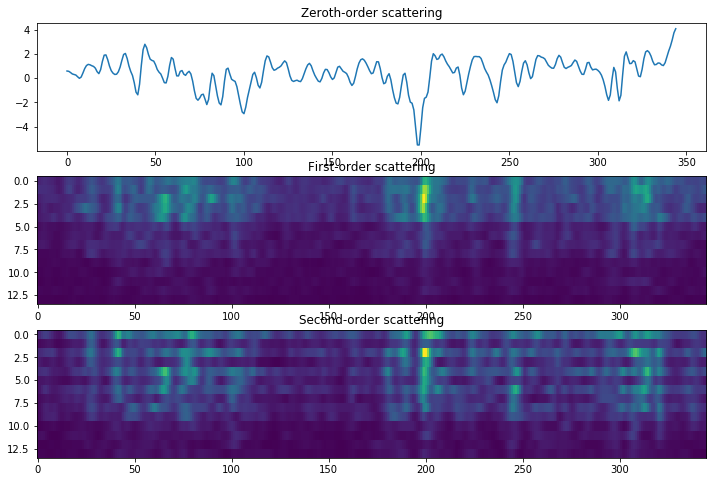

In [163]:
J = 4
Q = 4

scattering = np_wavelet_scatter_1d(J, len(decomp_signal), Q, max_order=2)

meta = scattering.meta()
order0 = np.where(meta['order'] == 0)
order1 = np.where(meta['order'] == 1)
order2 = np.where(meta['order'] == 2)

Sx = scattering(decomp_signal)
print(len(Sx[order0][0]))

plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(Sx[order0][0])
plt.title('Zeroth-order scattering')

plt.subplot(3, 1, 2)
plt.imshow(Sx[order1], aspect='auto')
plt.title('First-order scattering')

plt.subplot(3, 1, 3)
plt.imshow(Sx[order2], aspect='auto')
plt.title('Second-order scattering')


plt.show()

In [159]:
from model_util import WaveletScatter1d

torch_sig = torch.tensor(torch.from_numpy(decomp_signal), dtype=torch.float32)
coeff = WaveletScatter1d(torch_sig.shape, 4, 4).forward(torch_sig)

/home/kev/crunch/model/nb-model_xg-model-fr-model.ipynb:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


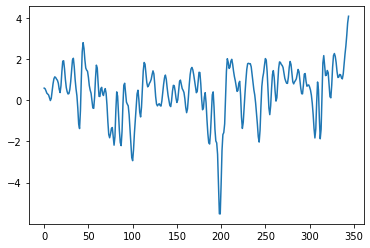

In [160]:
plt.plot(coeff[0][0])

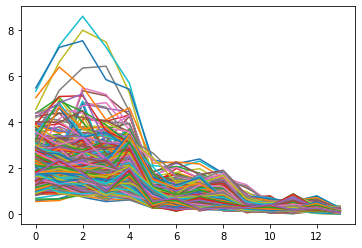

In [161]:
plt.plot(coeff[1])

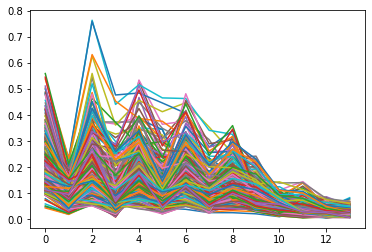

In [162]:
plt.plot(coeff[2])

In [34]:
coeff[2].shape

torch.Size([14, 345])

In [24]:
coeff[1].shape

torch.Size([14, 345])

In [27]:
coeff[2].shape

torch.Size([14, 345])

In [28]:
coeff[1]

tensor([[0.8557, 0.9119, 1.0135,  ..., 1.9130, 1.8364, 1.7555],
        [1.1814, 1.1521, 1.1323,  ..., 2.0893, 2.3048, 2.4005],
        [0.7487, 0.8032, 0.9066,  ..., 1.8554, 1.8232, 1.7896],
        ...,
        [0.0290, 0.0395, 0.0639,  ..., 0.1969, 0.1944, 0.1943],
        [0.1902, 0.1808, 0.1607,  ..., 0.2393, 0.2615, 0.2730],
        [0.0891, 0.0846, 0.0759,  ..., 0.0927, 0.0865, 0.0839]],
       device='cuda:0')

In [20]:
Sx[order0][0].shape

(345,)

In [46]:
Sx[order1].shape

(63, 87)

In [26]:
Sx[order2].shape

(158, 87)

### Choose Labels/Targets and Process

In [258]:
# predict ddir(t)
chosen_l = pd_split_ternary_to_binary(ld['hoc']['pba']['ddir'].replace(to_replace=-1, value=0))
chosen_t = pd_split_ternary_to_binary(td['hoc']['pba']['dret'])

In [ ]:
# predict thresholded direction: ddir1(t)
chosen_l_len = len(ld['hoc']['pba']['ddir1_log'].columns)
chosen_l = pd_split_ternary_to_binary(ld['hoc']['pba']['ddir1_log'])
chosen_l = chosen_l.sum(level=0)#+len(chosen_l.columns)
chosen_l = (chosen_l[chosen_l!=0] + chosen_l_len).fillna(0).astype(int)
chosen_l = df_add_midx_level(chosen_l, 'pba_hoc_hdxret1_ddir1', loc=1, name='id1')

chosen_t = pd_split_ternary_to_binary(td['hoc']['pba']['dret1_log']).abs().max(level=0)
chosen_t = df_add_midx_level(chosen_t, 'pba_hoc_hdxret1_dret1', loc=1, name='id1')
#chosen_l = chosen_l.sum(level=0)#+len(chosen_l.columns)
#chosen_l

In [15]:
# 'Predict' the present ddir(t-1)
chosen_l = pd_split_ternary_to_binary(df_del_midx_level(fd['d']['pba']['ddir']['pba_hoc_hdxret_ddir'].rename(columns={-1:'pba_hoc_hdxret_ddir'}), loc=1).replace(to_replace=-1, value=0).astype(int))
chosen_t = pd_split_ternary_to_binary(df_del_midx_level(fd['d']['pba']['dret']['pba_hoc_hdxret_dret'].rename(columns={-1:'pba_hoc_hdxret_dret'}), loc=1))

### Get Common Indexed Rows (Intersect First Level of MultiIndex)

In [259]:
year_interval = ('2009', '2018')
common_idx = midx_intersect(pd_get_midx_level(chosen_f), pd_get_midx_level(chosen_l), pd_get_midx_level(chosen_t))
common_idx = common_idx[(common_idx > year_interval[0]) & (common_idx < year_interval[1])]
feature_df, label_df, target_df = map(compose(partial(pd_rows, idx=common_idx), df_midx_restack), [chosen_f, chosen_l, chosen_t])
assert(all(feature_df.index.levels[0]==label_df.index.levels[0]))
assert(all(feature_df.index.levels[0]==target_df.index.levels[0]))

In [260]:
feature_df

9         10        11  \
id0        id1                                                          
2009-01-02 pba_open_pba_hohlca_hdmx     -0.854887 -1.000000  0.006382   
           pba_high_pba_hohlca_hdmx     -1.000000 -0.330963 -0.113402   
           pba_low_pba_hohlca_hdmx      -1.000000 -0.948160 -0.062400   
           pba_close_pba_hohlca_hdmx    -1.000000 -0.058166  0.020046   
           pba_avgPrice_pba_hohlca_hdmx -1.000000 -0.688267 -0.093641   
...                                           ...       ...       ...   
2017-12-29 pba_open_pba_hohlca_hdmx      1.000000  0.816224  0.422828   
           pba_high_pba_hohlca_hdmx      1.000000  0.475309  0.314815   
           pba_low_pba_hohlca_hdmx       1.000000  0.472727  0.460606   
           pba_close_pba_hohlca_hdmx     1.000000  0.617978  0.702247   
           pba_avgPrice_pba_hohlca_hdmx  1.000000  0.680039  0.451699   

                                               12        13        14  \
id0        id1                                                          
2009-01-02 pba_open_pba_hohlca_hdmx      0.079610  0.261673  0.565334   
           pba_high_pba_hohlca_hdmx      0.058656  0.360114  0.596161   
           pba_low_pba_hohlca_hdmx       0.088000  0.295360  0.470080   
           pba_close_pba_hohlca_hdmx     0.192902  0.493920  0.772593   
           pba_avgPrice_pba_hohlca_hdmx  0.065233  0.360852  0.580325   
...                                           ...       ...       ...   
2017-12-29 pba_open_pba_hohlca_hdmx      0.507538  0.306533  0.007897   
           pba_high_pba_hohlca_hdmx      0.285185  0.124691 -0.077778   
           pba_low_pba_hohlca_hdmx       0.566667  0.175758  0.263636   
           pba_close_pba_hohlca_hdmx     0.507022  0.210674  0.341292   
           pba_avgPrice_pba_hohlca_hdmx  0.539091  0.321021  0.193217   

                                               15        16  
id0        id1                                               
2009-01-02 pba_open_pba_hohlca_hdmx      0.846154  1.000000  
           pba_high_pba_hohlca_hdmx      1.000000  0.791681  
           pba_low_pba_hohlca_hdmx       0.853440  1.000000  
           pba_close_pba_hohlca_hdmx     0.912586  1.000000  
           pba_avgPrice_pba_hohlca_hdmx  0.951078  1.000000  
...                                           ...       ...  
2017-12-29 pba_open_pba_hohlca_hdmx      0.138550 -1.000000  
           pba_high_pba_hohlca_hdmx      0.227160 -1.000000  
           pba_low_pba_hohlca_hdmx      -0.886364 -1.000000  
           pba_close_pba_hohlca_hdmx    -0.786517 -1.000000  
           pba_avgPrice_pba_hohlca_hdmx  0.165438 -1.000000  

[11325 rows x 8 columns]

## PL Model

In [189]:
from model_util import init_layer, assert_has_shape_attr

In [190]:
from model.model_util import TemporalConvNet, ResidualBlock

In [191]:
class FFNet(nn.Module):
	"""
	"""
	def __init__(self, in_shape, block_sizes=[[20]], block_act='elu', out_act='relu', global_dropout=.2, no_dropout=[0],
                block_init='normal', out_init='normal', out_shapes=[2]):
		"""
		Args:
			in_shape (tuple): shape of the network's input tensor, expects a shape (in_channels, in_width)
			block_sizes (list * list): FF layer sizes in each block, or individual channel sizes per block in sequence
			block_act (str): activation function of each layer in each block
			out_act (str): output activation of each block
			global_dropout (float): dropout probability of an element to be zeroed for any layer not in no_dropout
			no_dropout (list): list of global layer indices to disable dropout on
			block_init (str): 
			out_init (str): 
			out_shapes (list): 
		"""
		super(FFNet, self).__init__()
		self.in_shape = block_in_shape = (in_shape[0]*in_shape[1], )
		blocks = []
		i = 0

		for b in range(len(block_sizes)):
			block_channel_list = block_sizes[b]
			layer_in_shape = block_in_shape
			layers = []

			for l, layer_out_shape in enumerate(block_channel_list):
				layer_out_shape = (layer_out_shape,)
				layers.append(('ff_{b}_{l}'.format(b=b, l=l, i=i), init_layer(nn.Linear(layer_in_shape[0], layer_out_shape[0], bias=True), act=block_act, init_method=block_init)))
				layers.append(('af_{b}_{l}'.format(b=b, l=l, i=i), PYTORCH_ACT_MAPPING.get(block_act)()))
				if (i not in no_dropout):
					layers.append(('do_{b}_{l}'.format(b=b, l=l, i=i), nn.Dropout(global_dropout)))
				layer_in_shape = layer_out_shape
				i += 1
			block_out_shape = layer_out_shape
			net = nn.Sequential(OrderedDict(layers))
			net.in_shape, net.out_shape = block_in_shape, block_out_shape
			blocks.append(('rb_{b}'.format(b=b), ResidualBlock(net, out_act, downsample_type='linear', init_method=out_init)))
			block_in_shape = block_out_shape
		self.out_shape = block_out_shape
		self.ffnet = nn.Sequential(OrderedDict(blocks))

	def forward(self, x):
		return self.ffnet(x)

In [192]:
class RNNet(nn.Module):
	"""
	"""
	def __init__(self, in_shape, rnn_type='gru', block_sizes=[20, 2], block_act='elu', out_act='relu', global_dropout=.2,
                block_init='normal', out_init='normal', out_shapes=[2]):
		"""
		Args:
			in_shape (tuple): shape of the network's input tensor, expects a shape (in_channels, in_width)
			rnn_type ('gru'|'lstm'):
			block_sizes (list * list): 
			block_act (str): activation function of each layer in each block
			out_act (str): output activation of each block
			global_dropout (float): dropout probability of an element to be zeroed for any layer not in no_dropout
			no_dropout (list): list of global layer indices to disable dropout on
			block_init (str): 
			out_init (str): 
			out_shapes (list): 
		"""
		super(RNNet, self).__init__()
		self.in_shape = (np.product(in_shape), )
		self.out_shape = (block_sizes[0], )
		layer_in_shape = self.in_shape[0]
		layer_out_shape = self.out_shape[0]
		if (rnn_type == 'gru'):
			rnn_fn = nn.GRU
		elif (rnn_type == 'lstm'):
			rnn_fn = nn.LSTM

		self.rnnet = rnn_fn(layer_in_shape, block_sizes[0], block_sizes[1], bias=True, batch_first=True, dropout=global_dropout)
		self.rnnet.in_shape = (layer_in_shape, )
		self.rnnet.out_shape = (layer_out_shape, )

# 		for b in range(len(block_sizes)):
# 			block_channel_list = block_sizes[b]
# 			layer_in_shape = block_in_shape
# 			layers = []

# 			for l, layer_out_shape in enumerate(block_channel_list):
# 				layer_out_shape = (layer_out_shape,)
# 				#layers.append(('{r}_{b}_{l}'.format(r=rnn_type, b=b, l=l, i=i), init_layer(rnn_fn(layer_in_shape[0], layer_out_shape[0], 1, bias=True, dropout=global_dropout), act=block_act, init_method=block_init)))
# 				layers.append(('{r}_{b}_{l}'.format(r=rnn_type, b=b, l=l, i=i), rnn_fn(layer_in_shape[0], layer_out_shape[0], 1, bias=True, batch_first=False, dropout=global_dropout)))
# 				#layers.append(('af_{b}_{l}'.format(b=b, l=l, i=i), PYTORCH_ACT_MAPPING.get(block_act)()))
# 				layer_in_shape = layer_out_shape
# 				i += 1
# 			block_out_shape = layer_out_shape
# 			net = nn.Sequential(OrderedDict(layers))
# 			net.in_shape, net.out_shape = block_in_shape, block_out_shape
# 			blocks.append(('b_{b}'.format(b=b), net))
# 			#blocks.append(('rb_{b}'.format(b=b), ResidualBlock(net, out_act, downsample_type='linear', init_method=out_init)))
# 			block_in_shape = block_out_shape
# 		self.out_shape = block_out_shape
# 		self.rnnet = nn.Sequential(OrderedDict(blocks))
		self.h0 = torch.randn(block_sizes[-1], 3, block_sizes[0])
		self.c0 = torch.randn(2, 3, 20)

	def forward(self, x):
		out, hn = self.rnnet(x, self.h0)

		return out

In [193]:
t_params = {
	'window_size': 20,
	'flatten_features': False,
	'shuffle_features': False,    
	'epochs': 200,
	'batch_size': 64*2,
	'loss': 'ce',
	'opt': {
		'name': 'adam',
		'kwargs': {
			'lr': .001
		}
	},
	'sch': {
#		'name': 'rpl',
#		'kwargs': {
#			'mode': 'min',
#			'factor': 0.1,
#			'patience': 10,
#			'threshold': 0.0001,
#			'threshold_mode': 'rel',
#			'cooldown': 0,
#			'min_lr': 0
#		}
	}
}

ffn_t_params = {
	'window_size': 20,
	'flatten_features': True,
	'shuffle_features': False,    
	'epochs': 200,
	'batch_size': 64*2,
	'loss': 'ce',
	'opt': {
		'name': 'adam',
		'kwargs': {
			'lr': .001
		}
	},
	'sch': {
#		'name': 'rpl',
#		'kwargs': {
#			'mode': 'min',
#			'factor': 0.1,
#			'patience': 10,
#			'threshold': 0.0001,
#			'threshold_mode': 'rel',
#			'cooldown': 0,
#			'min_lr': 0
#		}
	}
}

In [198]:
ffn_m_params = {
	'block_sizes': [[200, 200, 200, 200, 200, 200, 200, 200, 200, 200]],
	'block_act': 'relu',
	'out_act': 'gelu',
	'global_dropout': 0,
	'no_dropout': [0],
	'block_init': 'normal',
	'out_init': 'normal',
	'out_shapes': [2]#len(chosen_l.columns)*len(chosen_l.index.levels[1])], # directions * slots per direction
}

rnn_m_params = {
	'rnn_type': 'gru',
	'block_sizes': [20, 2],
	'block_act': 'relu',
	'out_act': 'relu',
	'global_dropout': 0,
	'block_init': 'normal',
	'out_init': 'normal',
	'out_shapes': [2]#len(chosen_l.columns)*len(chosen_l.index.levels[1])], # directions * slots per direction
}

tcn_m_params = {
	'pad_type': 'same',    
	'num_blocks': 1,
	#'block_channels': [[80, 80, 80]],
	'block_channels': [[70, 70, 70]],
	#'block_channels': [[70]],
	#'block_channels': [[80, 80, 80]],
	#'block_channels': [[80, 70, 60]],
	#'block_channels': [[70, 60, 50]],
	'block_act': 'relu',
	'out_act': 'relu',
	'block_init': 'kaiming_normal',
	'out_init': 'kaiming_normal',
	'kernel_sizes': [7],
	'dilation_index': 'global',
	'global_dropout': 0,
	'no_dropout': [0],
	'out_shapes': [2] # directions * slots per direction
}

In [204]:
mdl = GenericModel(TemporalConvNet, tcn_m_params, t_params, (feature_df, label_df, target_df))
display(mdl)

GenericModel(
  (loss): CrossEntropyLoss()
  (model): OutputLinear(
    (emb): TemporalConvNet(
      (convnet): Sequential(
        (rb_0): ResidualBlock(
          (net): Sequential(
            (tl_0_0): TemporalLayer1d(
              (layer): Sequential(
                (0): Conv1d(5, 700, kernel_size=(33,), stride=(1,), padding=(16,))
                (1): ReLU()
                (2): Dropout(p=0, inplace=False)
              )
            )
            (tl_0_1): TemporalLayer1d(
              (layer): Sequential(
                (0): Conv1d(700, 700, kernel_size=(33,), stride=(1,), padding=(32,), dilation=(2,))
                (1): ReLU()
                (2): Dropout(p=0, inplace=False)
              )
            )
            (tl_0_2): TemporalLayer1d(
              (layer): Sequential(
                (0): Conv1d(700, 700, kernel_size=(33,), stride=(1,), padding=(64,), dilation=(4,))
                (1): ReLU()
                (2): Dropout(p=0, inplace=False)
              )
   

In [205]:
#mdl = GenericModel(RNNet, rnn_m_params, t_params, (feature_df, label_df, target_df))
#display(mdl)

In [206]:
#mdl = GenericModel(FFNet, ffn_m_params, ffn_t_params, (feature_df, label_df, target_df))

In [207]:
escb = EarlyStopping(monitor='val_loss', min_delta=0.00, patience=30, verbose=False, mode='min')
trainer = pl.Trainer(max_epochs=t_params['epochs'], auto_lr_find=False, gpus=1, amp_level='O1', precision=16)

INFO:lightning:GPU available: True, used: True
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:Using 16bit precision.


In [208]:
trainer.fit(mdl)

INFO:lightning:
   | Name                                      | Type             | Params
---------------------------------------------------------------------------
0  | loss                                      | CrossEntropyLoss | 0     
1  | model                                     | OutputLinear     | 32 M  
2  | model.emb                                 | TemporalConvNet  | 32 M  
3  | model.emb.convnet                         | Sequential       | 32 M  
4  | model.emb.convnet.rb_0                    | ResidualBlock    | 32 M  
5  | model.emb.convnet.rb_0.net                | Sequential       | 32 M  
6  | model.emb.convnet.rb_0.net.tl_0_0         | TemporalLayer1d  | 116 K 
7  | model.emb.convnet.rb_0.net.tl_0_0.layer   | Sequential       | 116 K 
8  | model.emb.convnet.rb_0.net.tl_0_0.layer.0 | Conv1d           | 116 K 
9  | model.emb.convnet.rb_0.net.tl_0_0.layer.1 | ReLU             | 0     
10 | model.emb.convnet.rb_0.net.tl_0_0.layer.2 | Dropout          | 0     
11 | mod

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0


INFO:lightning:Detected KeyboardInterrupt, attempting graceful shutdown...


1

In [24]:
for i in range(5):
    mdl = TCNModel(m_params, t_params, (feature_df, label_df, target_df))
    trainer = pl.Trainer(max_nb_epochs=t_params['epochs'], gpus=1, amp_level='O1', use_amp=True)
    trainer.fit(mdl)

NameError: name 'TCNModel' is not defined

## Debug Data (Runtime Transforms)

### Split into Train/Val/Test and Convert to Numpy Tensor

In [261]:
train_np, val_np, test_np = zip(*map(pd_to_np_tvt, (feature_df, label_df, target_df)))
shapes = np.asarray(tuple(map(lambda tvt: tuple(map(np.shape, tvt)), (train_np, val_np, test_np))))
assert all(np.array_equal(a[:, 1:], b[:, 1:]) for a, b in pairwise(shapes)), 'feature, label, target shapes must be identical across splits'
assert all(len(np.unique(mat.T[0, :]))==1 for mat in shapes), 'first dimension (N) must be identical length in each split for all (feature, label, and target) tensors'

### Runtime Preproc

In [262]:
params = {
    'loss': 'ce',
    'batch_size': 1,
    'window_size': 20,
}

In [263]:
def __preproc__(data, m_params, overlap=True):
    x, y, z = temporal_preproc_3d(data, window_size=m_params['window_size'], apply_idx=[0]) if (overlap) else stride_preproc_3d(data, window_size=m_params['window_size'])
    if (m_params['loss'] in ('bce', 'bcel', 'ce', 'nll')):
        y_new = np.sum(y, axis=(1, 2), keepdims=False)		# Sum label matrices to scalar values
        if (y.shape[1] > 1):
            y_new += y.shape[1]								# Shift to range [0, C-1]
        if (m_params['loss'] in ('bce', 'bcel')):
            y_new = np.expand_dims(y_new, axis=-1)
        y = y_new
    return (x, y, z)

#@pl.data_loader
def train_dataloader(t_params, flt):
    logging.info('train_dataloader called')
    return batchify(t_params, __preproc__(flt), False)

#@pl.data_loader
def val_dataloader(t_params, flt):
    logging.info('val_dataloader called')
    return batchify(t_params, __preproc__(flt), False)

#@pl.data_loader
def test_dataloader(t_params, flt):
    logging.info('test_dataloader called')
    return batchify(t_params, __preproc__(flt), False)

### Overlapping Episodes:

In [264]:
train_ol_np = __preproc__(train_np, params)
val_ol_np = __preproc__(val_np, params)
test_ol_np = __preproc__(test_np, params)
print(tuple(map(lambda tvt: tuple(map(np.shape, tvt)), (train_np, val_np, test_np)))[0])
print(tuple(map(np.shape, train_ol_np)))
print(np_value_counts(train_ol_np[1]))

((1359, 5, 8), (1359, 1, 2), (1359, 1, 2))
((1340, 5, 160), (1340,), (1340, 1, 2))
(array([0., 1.]), array([593, 747]))


### Non-Overlapping Episodes:

In [265]:
train_nol_np = __preproc__(train_np, params, False)
val_nol_np = __preproc__(val_np, params, False)
test_nol_np = __preproc__(test_np, params, False)
print(tuple(map(lambda tvt: tuple(map(np.shape, tvt)), (train_np, val_np, test_np)))[0])
print(tuple(map(np.shape, train_nol_np)))

((1359, 5, 8), (1359, 1, 2), (1359, 1, 2))
((67, 5, 20, 8), (67, 2), (67, 1, 20, 2))


## Sklearn Tests

In [267]:
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier, ElasticNet
from sklearn.tree import DecisionTreeClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, StackingClassifier

In [268]:
x_train, y_train, z_train = train_ol_np
x_val, y_val, z_val = val_ol_np
x_test, y_test, z_test = test_ol_np

In [269]:
def np_collapse_last_two_dim(arr):
    return arr.reshape(arr.shape[0], arr.shape[1]*arr.shape[2])

In [270]:
x_train.reshape(1340, 800)

array([[-0.85488747, -1.        ,  0.00638226, ..., -0.42239411,
        -0.89877114, -1.        ],
       [ 0.18175721, -1.        ,  0.42723005, ..., -0.36880596,
         0.6830558 ,  0.86423747],
       [-1.        ,  1.        , -0.99684543, ...,  0.28795926,
         1.        ,  0.90277818],
       ...,
       [ 0.16315205,  0.71809101,  1.        , ...,  0.60172607,
         1.        ,  0.9803573 ],
       [-1.        ,  0.45670996,  0.06926407, ..., -0.32918006,
         0.58853927,  1.        ],
       [-0.42150538, -1.        ,  0.12688172, ...,  1.        ,
         0.96050104, -0.67073952]])

In [618]:
x_train_new = np_collapse_last_two_dim(x_train)
x_val_new = np_collapse_last_two_dim(x_val)
x_test_new = np_collapse_last_two_dim(x_test)

(13, 20)
(1, 20)
(8, 20)
(4, 20)


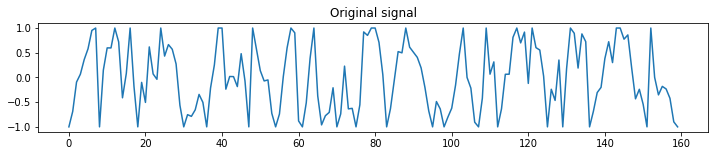

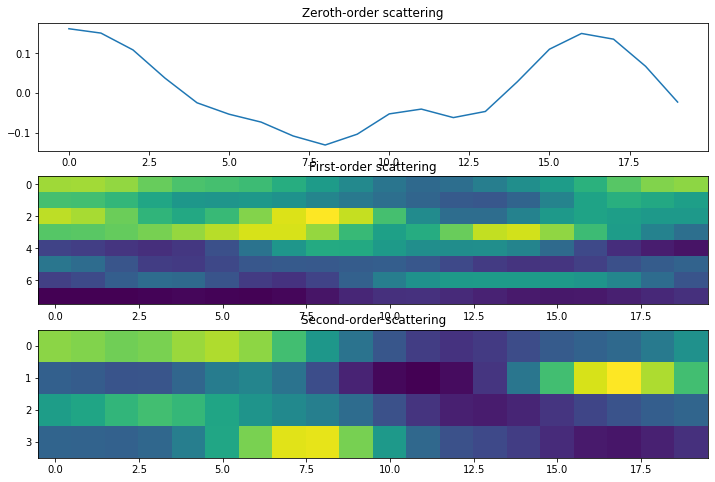

In [544]:
for i in range(1):
    decomp_signal = x_train[i][4]
    plt.figure(figsize=(12, 2))
    plt.plot(decomp_signal)
    plt.title("Original signal")

    J = 3
    Q = 3

    scattering = np_wavelet_scatter_1d(J, decomp_signal.shape, Q, max_order=2)

    meta = scattering.meta()
    order0 = np.where(meta['order'] == 0)
    order1 = np.where(meta['order'] == 1)
    order2 = np.where(meta['order'] == 2)

    Sx = scattering(decomp_signal)
    print(Sx.shape)

    plt.figure(figsize=(12, 8))

    plt.subplot(3, 1, 1)
    plt.plot(Sx[order0][0])
    #plt.imshow(Sx[order0], aspect='auto')
    plt.title('Zeroth-order scattering')
    print(Sx[order0].shape)

    plt.subplot(3, 1, 2)
    plt.imshow(Sx[order1], aspect='auto')
    plt.title('First-order scattering')
    print(Sx[order1].shape)

    plt.subplot(3, 1, 3)
    plt.imshow(Sx[order2], aspect='auto')
    plt.title('Second-order scattering')
    print(Sx[order2].shape)

    plt.show()

In [545]:
T = 2**13
J = 5
Q = 8
phi_f, psi1_f, psi2_f, _ = scattering_filter_factory(np.log2(T), J, Q)
# Analytic Morlet Wavelets, Frequency Domain

Text(0.5, 1.0, 'First-order filters (Q = 8)')

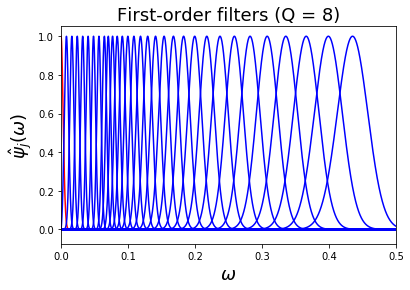

In [546]:
plt.figure()
plt.plot(np.arange(T)/T, phi_f[0], 'r')

for psi_f in psi1_f:
    plt.plot(np.arange(T)/T, psi_f[0], 'b')

plt.xlim(0, 0.5)

plt.xlabel(r'$\omega$', fontsize=18)
plt.ylabel(r'$\hat\psi_j(\omega)$', fontsize=18)
plt.title('First-order filters (Q = {})'.format(Q), fontsize=18)

Text(0.5, 1.0, 'Second-order filters (Q = 1)')

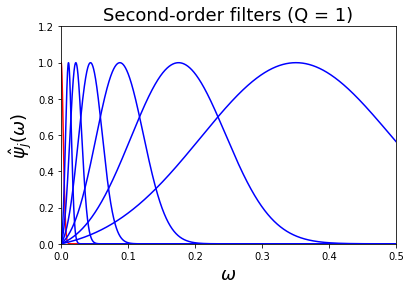

In [547]:
plt.figure()
plt.plot(np.arange(T)/T, phi_f[0], 'r')
for psi_f in psi2_f:
    plt.plot(np.arange(T)/T, psi_f[0], 'b')
plt.xlim(0, 0.5)
plt.ylim(0, 1.2)
plt.xlabel(r'$\omega$', fontsize=18)
plt.ylabel(r'$\hat\psi_j(\omega)$', fontsize=18)
plt.title('Second-order filters (Q = {})'.format(1), fontsize=18)

In [619]:
# Logistic Regression
clf = LogisticRegression(C=10**-2, l1_ratio=.9, penalty='elasticnet', random_state=0, solver='saga').fit(x_train_new, y_train)
sc = clf.score(x_val_new, y_val)
print('base :', y_val.mean())
print('score:', sc)
print('diff : {:%}'.format((sc-y_val.mean())))

base : 0.5092165898617511
score: 0.5092165898617511
diff : 0.000000%


In [620]:
# SGDClassifier
clf = SGDClassifier(alpha=10**-2, l1_ratio=.8, loss='log', penalty='elasticnet', random_state=0).fit(x_train_new, y_train)
sc = clf.score(x_val_new, y_val)
print('base :', y_val.mean())
print('score:', sc)
print('diff : {:%}'.format((sc-y_val.mean())))

base : 0.5092165898617511
score: 0.5069124423963134
diff : -0.230415%


In [621]:
# SGDClassifier
clf = SGDClassifier(alpha=10**-5, l1_ratio=.1, loss='modified_huber', max_iter=1000, penalty='elasticnet', random_state=0).fit(x_train_new, y_train)
sc = clf.score(x_val_new, y_val)
print('base :', y_val.mean())
print('score:', sc)
print('diff : {:%}'.format((sc-y_val.mean())))

base : 0.5092165898617511
score: 0.5230414746543779
diff : 1.382488%


In [622]:
# RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, criterion='gini', bootstrap=True, max_depth=4, min_impurity_decrease=0, random_state=0).fit(x_train_new, y_train)
sc = clf.score(x_val_new, y_val)
print('base :', y_val.mean())
print('score:', sc)
print('diff : {:%}'.format((sc-y_val.mean())))

base : 0.5092165898617511
score: 0.5069124423963134
diff : -0.230415%


In [635]:
# RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, criterion='entropy', bootstrap=True, max_depth=None,
                             min_impurity_decrease=0, random_state=0).fit(x_train_new, y_train)
sc = clf.score(x_val_new, y_val)
print('base :', y_val.mean())
print('score:', sc)
print('diff : {:%}'.format((sc-y_val.mean())))

base : 0.5092165898617511
score: 0.4769585253456221
diff : -3.225806%


In [624]:
# RandomForestClassifier
clf = RandomForestClassifier(n_estimators=7, class_weight='balanced_subsample', criterion='entropy',
                             bootstrap=True, max_depth=3, min_impurity_decrease=0, random_state=0).fit(x_train_new, y_train)
sc = clf.score(x_val_new, y_val)
print('base :', y_val.mean())
print('score:', sc)
print('diff : {:%}'.format((sc-y_val.mean())))

base : 0.5092165898617511
score: 0.4930875576036866
diff : -1.612903%


In [625]:
# RandomForestClassifier
clf = RandomForestClassifier(n_estimators=1000, class_weight='balanced_subsample', criterion='entropy',
                             bootstrap=True, max_depth=4, min_impurity_decrease=0, random_state=0).fit(x_train_new, y_train)
sc = clf.score(x_val_new, y_val)
print('base :', y_val.mean())
print('score:', sc)
print('diff : {:%}'.format((sc-y_val.mean())))

base : 0.5092165898617511
score: 0.49078341013824883
diff : -1.843318%


In [626]:
# GradientBoostingClassifier
clf = GradientBoostingClassifier(loss='deviance', learning_rate=0.1, n_estimators=100, subsample=1.0,
                                 criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1,
                                 min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0, random_state=0).fit(x_train_new, y_train)
sc = clf.score(x_val_new, y_val)
print('base :', y_val.mean())
print('score:', sc)
print('diff : {:%}'.format((sc-y_val.mean())))

base : 0.5092165898617511
score: 0.4861751152073733
diff : -2.304147%


In [627]:
# GradientBoostingClassifier
clf = GradientBoostingClassifier(loss='exponential', learning_rate=0.1, n_estimators=100, subsample=1.0,
                                 criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1,
                                 min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0, random_state=0).fit(x_train_new, y_train)
sc = clf.score(x_val_new, y_val)
print('base :', y_val.mean())
print('score:', sc)
print('diff : {:%}'.format((sc-y_val.mean())))

base : 0.5092165898617511
score: 0.4861751152073733
diff : -2.304147%


In [628]:
# HistGradientBoostingClassifier
clf = HistGradientBoostingClassifier(loss='auto', learning_rate=0.1, max_iter=100, max_leaf_nodes=31,
                                     max_depth=4, min_samples_leaf=20, l2_regularization=0.0, max_bins=255, random_state=0).fit(x_train_new, y_train)
sc = clf.score(x_val_new, y_val)
print('base :', y_val.mean())
print('score:', sc)
print('diff : {:%}'.format((sc-y_val.mean())))

base : 0.5092165898617511
score: 0.46543778801843316
diff : -4.377880%


In [629]:
# RF Alt 1
clf1 = DecisionTreeClassifier(criterion='entropy', max_depth=3, max_features='auto', class_weight='balanced')
clf = BaggingClassifier(base_estimator=clf1, bootstrap=True, bootstrap_features=False, n_estimators=100, random_state=0).fit(x_train_new, y_train)
sc = clf.score(x_val_new, y_val)
print('base :', y_val.mean())
print('score:', sc)
print('diff : {:%}'.format((sc-y_val.mean())))

base : 0.5092165898617511
score: 0.532258064516129
diff : 2.304147%


In [630]:
# RF Alt 2
clf = RandomForestClassifier(n_estimators=1, class_weight='balanced_subsample', criterion='entropy',
                             bootstrap=False, max_depth=3, min_impurity_decrease=0, random_state=0)
clf = BaggingClassifier(base_estimator=clf1, bootstrap=True, bootstrap_features=False, n_estimators=1000, random_state=0).fit(x_train_new, y_train)
sc = clf.score(x_val_new, y_val)
print('base :', y_val.mean())
print('score:', sc)
print('diff : {:%}'.format((sc-y_val.mean())))

base : 0.5092165898617511
score: 0.5069124423963134
diff : -0.230415%


In [598]:
random_states = range(10)
results = np.zeros(len(random_states))
y_mean = y_val.mean()
for r in random_states:
        # RandomForestClassifier
    clf = RandomForestClassifier(n_estimators=100, class_weight=None, criterion='entropy',
                                 bootstrap=True, max_depth=None, min_impurity_decrease=0, random_state=r).fit(x_train_new, y_train)
    sc = clf.score(x_val_new, y_val)
    diff = sc-y_mean
    results[r] = diff*100
    #print('base :', y_val.mean())
    #print('score:', sc)
    #print('diff : {:%}'.format((sc-y_val.mean())))
print(results)
print(results.mean())

[ 2.76497696 -2.99539171 -3.4562212   2.07373272  1.38248848 -1.61290323
 -0.92165899  0.46082949 -1.84331797 -3.68663594]
-0.783410138248844


In [67]:
# Few Shot Tests
# XXX - Need to update for code changes
tr_split = .75
w = params['window_size']
tr, ts = int(tr_split*w), (1-tr_split)*w
print(tr, ts)

scs = []
for x, y, z in zip(*train_nol_np):
    x, y = x.T, y
    print(x.shape)
    print(x[0:tr].shape)
    print(x[tr:].shape)
    break
    clf = LogisticRegression(C=10**-2, l1_ratio=.9, penalty='elasticnet', random_state=0, solver='saga').fit(x[0:tr], y[0:tr].squeeze())
    #clf = LinearRegression().fit(x[0:tr], y[0:tr].squeeze())
    #yh = clf.predict(x[tr:])
    #|yp = clf.predict_proba(x[tr:])
    sc = clf.score(x[tr:], y[tr:].squeeze())
    scs.append(sc)
    #print(sc)
    #print(x)
    #print(y.squeeze())
    #print(z.T)

15 5.0
(160, 5)
(15, 5)
(145, 5)


In [68]:
(np.array(scs).mean()-train_nol[1].squeeze().mean())*100

/home/kev/crunch/model/nb-model_xg-model-data-fi.ipynb:1: RuntimeWarning: Mean of empty slice.
  {
/home/kev/miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


NameError: name 'train_nol' is not defined